In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
data_path = "../data/wpbc.data"
usecols = [1] + list(range(3,35))
df = pd.read_csv(data_path, header=None, usecols=usecols)
df

,1,3,4,5,6,7,8,9,10,11,...,25,26,27,28,29,30,31,32,33,34
0,N,18.02,27.60,117.50,1013.0,0.09489,0.10360,0.10860,0.07055,0.1865,...,139.70,1436.0,0.11950,0.1926,0.3140,0.11700,0.2677,0.08113,5.0,5
1,N,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,184.60,2019.0,0.16220,0.6656,0.7119,0.26540,0.4601,0.11890,3.0,2
2,N,21.37,17.44,137.50,1373.0,0.08836,0.11890,0.12550,0.08180,0.2333,...,159.10,1949.0,0.11880,0.3449,0.3414,0.20320,0.4334,0.09067,2.5,0
3,N,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,98.87,567.7,0.20980,0.8663,0.6869,0.25750,0.6638,0.17300,2.0,0
4,R,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,152.20,1575.0,0.13740,0.2050,0.4000,0.16250,0.2364,0.07678,3.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,N,22.52,21.92,146.90,1597.0,0.07592,0.09162,0.06862,0.06367,0.1728,...,162.10,1902.0,0.08191,0.1319,0.1056,0.09378,0.2061,0.05788,6.0,2
194,N,15.44,31.18,101.00,740.4,0.09399,0.10620,0.13750,0.06500,0.1735,...,112.60,929.0,0.12720,0.2362,0.2975,0.12860,0.2914,0.08024,1.5,0
195,N,17.17,29.19,110.00,915.3,0.08952,0.06655,0.06583,0.05068,0.1793,...,132.50,1295.0,0.12610,0.1572,0.2141,0.09520,0.3362,0.06033,3.7,0
196,R,21.42,22.84,145.00,1440.0,0.10700,0.19390,0.23800,0.13180,0.1884,...,198.30,2375.0,0.14980,0.4379,0.5411,0.22150,0.2832,0.08981,3.0,?


### (b) Select the first 130 non-recurrent cases and the first 37 recurrent cases as your training set. Add record #197 in the data set to your training set as well.

In [3]:
num_N = 130
num_R = 37
train_data = pd.concat([df[df.iloc[:,0] == "N"][:num_N],
                        df[df.iloc[:,0] == "R"][:num_R],
                        df.iloc[196,:].to_frame().T])
test_data = df.drop(train_data.index)
train_data.shape, test_data.shape, df.shape

((168, 33), (30, 33), (198, 33))

### (c) Replace the missing features with the median of the lymph node feature in your training set. 

In [4]:
num_q = np.count_nonzero(train_data.iloc[:,-1] == '?')
print(f"In the beginning, the number of ? : {num_q}")
# replace ? to mean of other values
ly_np = np.asarray(train_data[train_data.iloc[:,-1] != "?"].iloc[:,-1], dtype=float)
ly_mean = ly_np.mean()
train_data.iloc[:,-1] = train_data.iloc[:,-1].replace('?',ly_mean)

num_q = np.count_nonzero(train_data.iloc[:,-1] == '?')
print(f"Now, the number of ? : {num_q}")

In the beginning, the number of ? : 4
Now, the number of ? : 0


### (d) Binary Classification Using Naive Bayes’ Classifiers

In [5]:
# split data
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((168, 32), (168,), (30, 32), (30,))

##### (i) Solve the problem using a Naive Bayes’ classifier. Use Gaussian class condi- tional distributions. Report the confusion matrix, ROC, precision, recall, F1 score, and AUC for both the train and test data sets.

Here, I assume non-recurrent as null hypothesis, i.e. negative event. So recurrent is positive event

In [6]:
def get_results(cm):
    ''' Get recall, specificity, precision, and F1 score from confusion matrix
    Parameters
    ----------
    cm : confusion matrix
    '''
    TP = np.diag(cm) # True Positive
    FP = cm.sum(axis=0) - TP  # False Positive
    FN = cm.sum(axis=1) - TP # False Negative
    TN = cm.sum() - (FP + FN + TP) # True Negative

    # True positive rate, sensitivity, hit rate or recall
    TPR = TP/(TP+FN)
    # True negative rate or specificity
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # F1 score
    F1 = 2*PPV*TPR/(PPV+TPR)
    return TPR, TNR, PPV, F1
    
def show_results(gnb, X, y, name):
    '''show confusion matrix, recall, precision, F1 score
    Parameters
    ----------
    gnb : Gaussian Naive Classifer object
    X : array-like (n_samples, n_features)
    y : array-like (n_samples,)
    name : specific name associated with input data
    '''
    y_pred = gnb.predict(X)
    cm = confusion_matrix(y_true=y, y_pred=y_pred, labels=gnb.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
    TPR, TNR, PPV, F1 = get_results(cm)
    print(f"{name} recall : {TPR[1]:.2f}")
    print(f"{name} precision : {PPV[1]:.2f}")
    print(f"{name} F1 score : {F1[1]:.2f}")
    print(f"{name} confusion matrix :")
    disp.plot()
    plt.show()

train recall : 0.47
train precision : 0.36
train F1 score : 0.41
train confusion matrix :


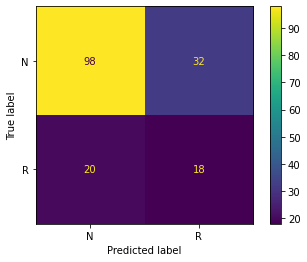

test recall : 0.33
test precision : 0.30
test F1 score : 0.32
test confusion matrix :


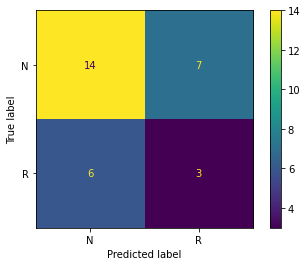

In [7]:
gnb = GaussianNB().fit(X_train, y_train)
show_results(gnb, X_train, y_train, 'train')
show_results(gnb, X_test, y_test, 'test')

In [8]:
def plot_roc(y_true, y_score, name=None):
    '''
    Parameters
    ----------
    y_true: ndarray of shape (n_samples,) True binary labels.
    y_score: ndarray of shape (n_samples,) Target scores
    name : string add before "Receiver operating characteristic"
    '''
    fpr, tpr, _ = roc_curve(y_true, y_score, pos_label='R')
    area = auc(fpr, tpr)
    plt.figure()
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = %0.2f)" % area,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(name+" Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

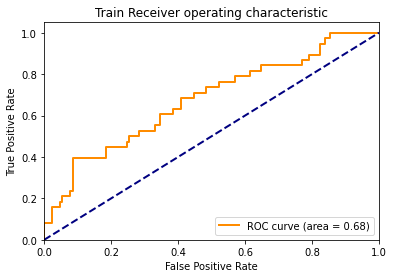

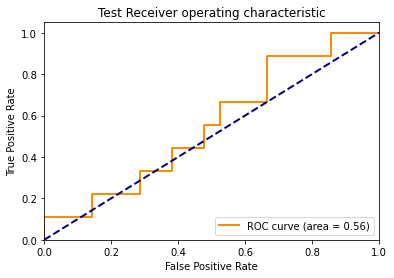

In [9]:
scores = gnb.predict_proba(X_train)[:, 1]
plot_roc(y_train, scores, name="Train")
scores = gnb.predict_proba(X_test)[:, 1]
plot_roc(y_test, scores, name="Test")

##### ii. This data set is rather imbalanced. Balance your data set using SMOTE, by downsampling the common class in the training set to 90 instances and upsampling the uncommon class to 90 instances. Use k = 5 nearest neighbors in SMOTE. Remember not to change the balance of the test set. Report the confusion matrix, ROC, precision, recall, F1 score, and AUC for both the train and test data sets. Does SMOTE help?

In [10]:
print("Original data : ", Counter(y_train))
sm = SMOTE(sampling_strategy={'N':130, 'R':90},random_state=42, k_neighbors=5)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
print("After adding new data for minority : ", Counter(y_sm))
rus = RandomUnderSampler(sampling_strategy='majority',random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_sm, y_sm)
print("After delete some data from majority : ", Counter(y_resampled))

Original data :  Counter({'N': 130, 'R': 38})
After adding new data for minority :  Counter({'N': 130, 'R': 90})
After delete some data from majority :  Counter({'N': 90, 'R': 90})


Resampled train recall : 0.66
Resampled train precision : 0.69
Resampled train F1 score : 0.67
Resampled train confusion matrix :


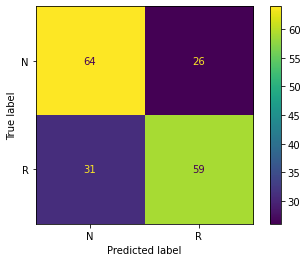

Original train after resample recall : 0.58
Original train after resample precision : 0.34
Original train after resample F1 score : 0.43
Original train after resample confusion matrix :


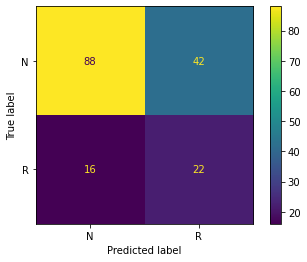

test after resample recall : 0.44
test after resample precision : 0.36
test after resample F1 score : 0.40
test after resample confusion matrix :


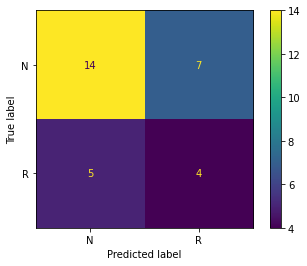

test before resample recall : 0.33
test before resample precision : 0.30
test before resample F1 score : 0.32
test before resample confusion matrix :


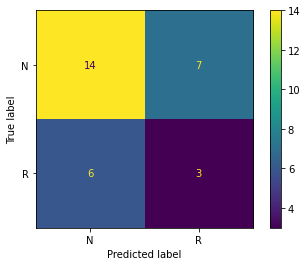

In [11]:
gnb_resampled = GaussianNB().fit(X_resampled, y_resampled)
show_results(gnb_resampled, X_resampled, y_resampled, 'Resampled train')
show_results(gnb_resampled, X_train, y_train, 'Original train after resample')
show_results(gnb_resampled, X_test, y_test, 'test after resample')
show_results(gnb, X_test, y_test, 'test before resample')

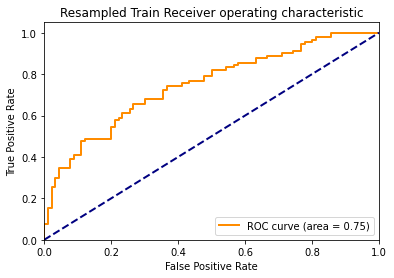

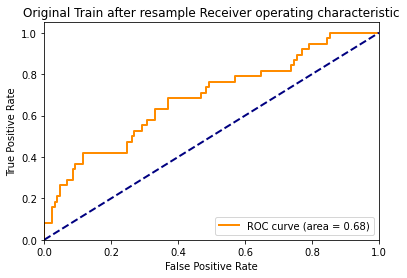

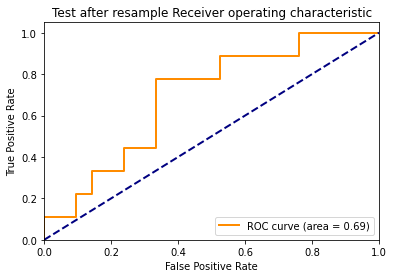

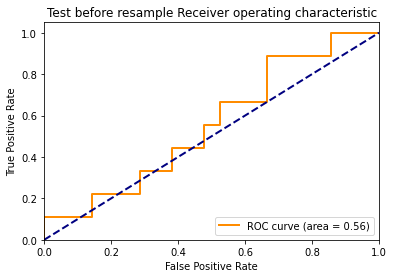

In [14]:
scores = gnb_resampled.predict_proba(X_resampled)[:, 1]
plot_roc(y_resampled, scores, name="Resampled Train")
scores = gnb_resampled.predict_proba(X_train)[:, 1]
plot_roc(y_train, scores, name="Original Train after resample")
scores = gnb_resampled.predict_proba(X_test)[:, 1]
plot_roc(y_test, scores, name="Test after resample")
scores = gnb.predict_proba(X_test)[:, 1]
plot_roc(y_test, scores, name="Test before resample")

Compare above confusion matrix, ROC, precision, recall, F1 score, and AUC for test, we can see SMOTE helps a little.